In [61]:
from datasets import PollenDataset
import matplotlib.pyplot as plt

In [2]:
dataset = PollenDataset()

In [3]:
dataset[0][-1].shape

torch.Size([32, 32, 32])

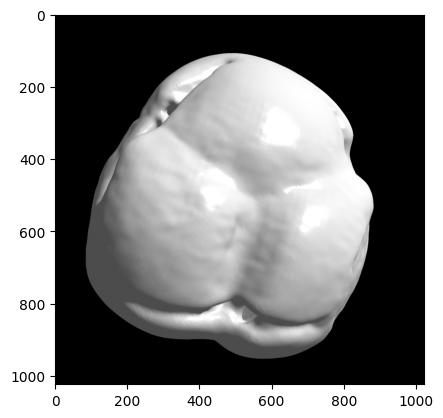

In [115]:
plt.imshow(dataset[180+9][0][0], cmap='gray')

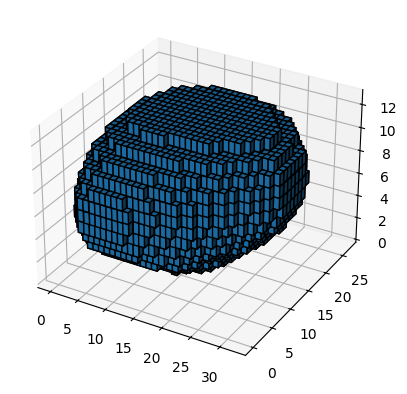

In [ ]:
# plot the 3d voxel grid
def plot_voxel_grid(voxel_grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_grid, edgecolor='k')
    plt.show()
    
plot_voxel_grid(dataset[10][-1])

In [5]:
# train_simple.py
import os, torch
from datetime import datetime as dt
from torch.utils.data import DataLoader
import torchvision.transforms as T

from models.encoder import Encoder
from models.decoder import Decoder
from models.refiner import Refiner
from models.merger  import Merger

from datasets.pollen_dataset import PollenDataset

from config import cfg

def batch_iou(pred_vol, gt_vol, thresh=0.5, eps=1e-6, reduction="mean"):
    """
    pred_vol : Tensor  [B, 1, D, H, W]  – probabilities in [0,1]
    gt_vol   : Tensor  [B, 1, D, H, W]  – binary (0/1) occupancy
    thresh   : float or (list/tuple)     – threshold(s) used to binarise pred_vol
    eps      : float                     – small value to avoid division-by-zero
    reduction: "none" | "mean" | "sum"   – behaviour identical to PyTorch losses

    Returns
    -------
    iou      : Tensor
        * shape [B]   if reduction=="none" and single threshold
        * shape [B,T] if reduction=="none" and multiple thresholds
        * scalar      otherwise
    """
    if isinstance(thresh, (list, tuple)):
        # ––– multiple thresholds at once –––
        ious = []
        for t in thresh:
            ious.append(batch_iou(pred_vol, gt_vol, t, eps, reduction="none"))
        ious = torch.stack(ious, dim=-1)  # [B, T]
        if reduction == "none":
            return ious
        elif reduction == "mean":
            return ious.mean()
        elif reduction == "sum":
            return ious.sum()
        else:
            raise ValueError(f"Unknown reduction: {reduction}")

    # ––– single threshold –––
    pred_bin = (pred_vol >= thresh)          # bool
    gt_bin   = (gt_vol   >= 0.5)             # ensure bool even if 0/1 floats

    inter = (pred_bin & gt_bin).float().sum(dim=(1,2,3,4))   # [B]
    union = (pred_bin | gt_bin).float().sum(dim=(1,2,3,4))   # [B]

    iou = inter / (union + eps)                              # [B]

    if reduction == "none":
        return iou
    elif reduction == "mean":
        return iou.mean()            # scalar
    elif reduction == "sum":
        return iou.sum()             # scalar
    else:
        raise ValueError(f"Unknown reduction: {reduction}")



In [75]:
# ---------- CONFIG ------------
BATCH_SIZE   = 8
NUM_EPOCHS   = 500
LR           = 1e-4
OUT_DIR      = "runs/" + dt.now().strftime("%Y%m%dT%H%M%S")
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
# ------------------------------

print(f"Using device: {DEVICE}")

# 1) Data
img_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),        # gray ➜ fake-RGB
    T.Normalize([0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5]),
])

train_ds = PollenDataset(image_transforms=img_tfms)
train_ds_subset = torch.utils.data.Subset(train_ds, range(0,180))  # use only the sample at index 55
train_dl = DataLoader(train_ds_subset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=0)              # keep 0 until pickling fixed



# 2) Model
enc = Encoder(cfg).to(DEVICE)
dec = Decoder(cfg).to(DEVICE)
ref = Refiner(cfg).to(DEVICE)
mer = Merger(cfg).to(DEVICE)

# 3) Optimiser & loss
params = list(enc.parameters()) + list(dec.parameters()) \
       + list(ref.parameters()) + list(mer.parameters())
opt  = torch.optim.Adam(params, lr=LR, betas=(0.9, 0.999))
bce  = torch.nn.BCELoss()

if torch.cuda.is_available():
       print('[INFO] CUDA is available, moving networks to GPU ...')
       enc = torch.nn.DataParallel(enc).cuda()
       dec = torch.nn.DataParallel(dec).cuda()
       ref = torch.nn.DataParallel(ref).cuda()
       mer = torch.nn.DataParallel(mer).cuda()

print('[INFO] %s Loading weights from %s onto %s ...' % (dt.now(), "./pretrained/Pix2Vox-A-ShapeNet.pth", DEVICE))
checkpoint = torch.load("./pretrained/Pix2Vox-A-ShapeNet.pth", map_location=DEVICE, weights_only=False)
epoch_idx = checkpoint['epoch_idx']
enc.load_state_dict(checkpoint['encoder_state_dict'])
dec.load_state_dict(checkpoint['decoder_state_dict'])

Using device: cuda


c:\Users\fahrn\Documents\Classes\bat\Pix2Vox\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fahrn\Documents\Classes\bat\Pix2Vox\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] CUDA is available, moving networks to GPU ...
[INFO] 2025-05-26 14:39:05.733397 Loading weights from ./pretrained/Pix2Vox-A-ShapeNet.pth onto cuda ...


<All keys matched successfully>

In [95]:
#test_ds = PollenDataset(image_transforms=img_tfms)
test_ds_subset = torch.utils.data.Subset(train_ds, range(180,206))  # use only the sample at index 55
test_dl = DataLoader(test_ds_subset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=0)

In [77]:
MERGER_KICKIN = 50
REFINER_KICKIN = 100

# ---------------- TRAINING LOOP ---------------- #
best_iou = 0.0
for epoch in range(NUM_EPOCHS):
    enc.train(); dec.train(); ref.train(); mer.train()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}...")
    for (left, right), _, _, voxels in train_dl:
        # ---------- images ----------
        if left.shape[1] == 1:                       # gray ➔ RGB
            left  = left.repeat(1, 3, 1, 1)
            right = right.repeat(1, 3, 1, 1)
        renderings = torch.stack([left, right], dim=1).to(DEVICE)   # [B,2,3,H,W]

        # ---------- voxels ----------
        vox = voxels.to(torch.float32).to(DEVICE)               # [B,32,32,32]

        # ---------- forward ----------
        feats        = enc(renderings)
        raw, gen     = dec(feats)                    # gen: [B,V,32³]  (already float)
        gen          = mer(raw, gen) if epoch >= MERGER_KICKIN else gen.mean(1)
        if epoch >= REFINER_KICKIN:
            gen = ref(gen)                           # [B,32,32,32]

        loss = bce(gen, vox) * 10.0                  # ✓ dtype/shape match now
        
        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Loss: {loss.item():.4f}")
    # when you compute IoU add the channel dim *there*, not during training
    iou = batch_iou(gen.detach().unsqueeze(1),
                    vox.detach().unsqueeze(1),
                    reduction="mean").item()

Epoch 1/500...
Epoch 1/500: Loss: 9.4955
Epoch 2/500...
Epoch 2/500: Loss: 8.1879
Epoch 3/500...
Epoch 3/500: Loss: 9.0237
Epoch 4/500...
Epoch 4/500: Loss: 14.6076
Epoch 5/500...
Epoch 5/500: Loss: 5.3918
Epoch 6/500...
Epoch 6/500: Loss: 6.2807
Epoch 7/500...
Epoch 7/500: Loss: 4.9079
Epoch 8/500...
Epoch 8/500: Loss: 5.3915
Epoch 9/500...
Epoch 9/500: Loss: 5.4724
Epoch 10/500...
Epoch 10/500: Loss: 4.4287
Epoch 11/500...
Epoch 11/500: Loss: 5.2094
Epoch 12/500...
Epoch 12/500: Loss: 2.8365
Epoch 13/500...
Epoch 13/500: Loss: 3.6622
Epoch 14/500...
Epoch 14/500: Loss: 4.3556
Epoch 15/500...
Epoch 15/500: Loss: 3.5662
Epoch 16/500...
Epoch 16/500: Loss: 3.9934
Epoch 17/500...
Epoch 17/500: Loss: 2.9144
Epoch 18/500...
Epoch 18/500: Loss: 2.3288
Epoch 19/500...
Epoch 19/500: Loss: 2.8599
Epoch 20/500...
Epoch 20/500: Loss: 2.8248
Epoch 21/500...
Epoch 21/500: Loss: 2.5449
Epoch 22/500...
Epoch 22/500: Loss: 2.5013
Epoch 23/500...
Epoch 23/500: Loss: 3.5465
Epoch 24/500...
Epoch 24/500

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


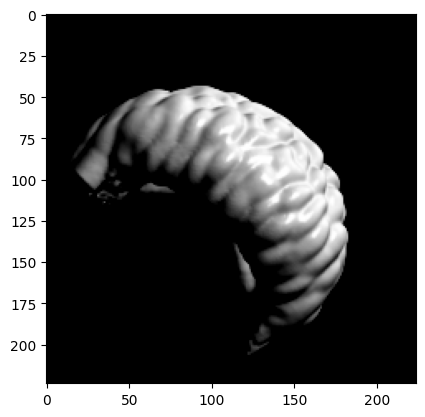

In [70]:
plt.imshow(train_ds_subset[0][0][0].permute(1,2,0).cpu().numpy())

In [71]:
next(iter(train_dl))

[[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.]],
  
           [[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.]],
  
           [[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.]]]]),
  tensor([[[[-1., -1., -1.,  ..., -1.

In [96]:
(left, right), _, _, voxels = next(iter(test_dl)) # get first sample

if left.shape[1] == 1:                       # gray ➔ RGB
    left  = left.repeat(1, 3, 1, 1)
    right = right.repeat(1, 3, 1, 1)
renderings = torch.stack([left, right], dim=1).to(DEVICE) 

feats = enc(renderings)
raw, gen = dec(feats)                    # gen: [B,V,32³]  (already float)
gen = mer(raw, gen)
gen = ref(gen)     

In [108]:
reconst = gen.detach().cpu().numpy() > 0.5 # [32,32,32]

In [109]:
reconst.shape

(8, 32, 32, 32)

In [122]:
iou = batch_iou(gen.cpu().detach().unsqueeze(1),
                voxels.cpu().detach().unsqueeze(1),
                reduction="none")
iou

tensor([0.5886, 0.7113, 0.5037, 0.7179, 0.6573, 0.8043, 0.8135, 0.6931])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


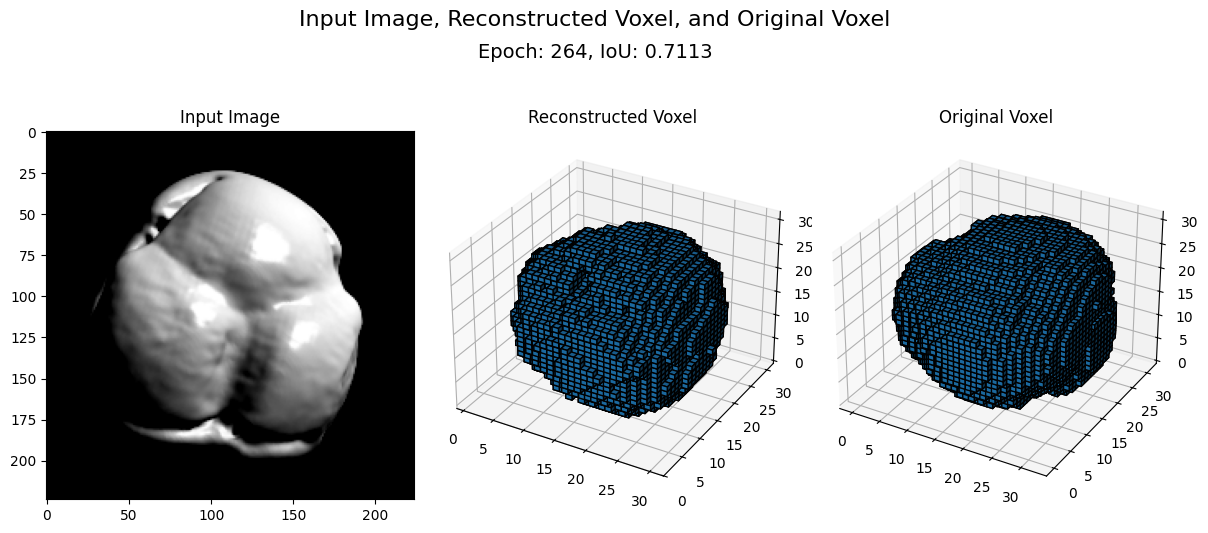

In [127]:
sample_idx = 1

fig = plt.figure(figsize=(12, 6))

fig.suptitle("Input Image, Reconstructed Voxel, and Original Voxel", fontsize=16)

fig.text(0.5, 0.90, f"Epoch: {epoch+1}, IoU: {iou[sample_idx]:.4f}", ha='center', fontsize=14)

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Input Image")
ax1.imshow(left[sample_idx].cpu().squeeze(0).permute(1, 2, 0).numpy())

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title("Reconstructed Voxel")
ax2.voxels(reconst[sample_idx], edgecolor='k')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_title("Original Voxel")
ax3.voxels(voxels[sample_idx].detach().cpu().numpy() > 0.5, edgecolor='k')

plt.tight_layout()

plt.show()


In [44]:
batch_iou(gen.cpu().detach().unsqueeze(1),
          voxels.cpu().detach().unsqueeze(1),
          reduction="mean").item()

0.9834005832672119